In [1]:
%%capture
!pip install diffusers transformers accelerate scipy safetensors

In [2]:
%%capture
%cd ..

In [3]:
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=None if torch.backends.mps.is_available() else torch.float16)  

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
pipe = pipe.to(device)
pipe.enable_attention_slicing()

In [5]:
import taesd
import time
from PIL import Image
import numpy as np

taesd_dec = taesd.Decoder().to(device).requires_grad_(False)
taesd_dec.load_state_dict(torch.load("taesd_decoder.pth", map_location=device, weights_only=True))

def get_pred_original_sample(sched, model_output, timestep, sample):
    alpha_prod_t = sched.alphas_cumprod[timestep]
    return (sample - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5

preview_images = []
preview_handle = None

def add_taesd_previewing(pipe, taesd_dec):
    sched = pipe.scheduler
    if not hasattr(sched, "_step"):
        sched._step = sched.step
    @torch.no_grad()
    def step_and_preview(*args, **kwargs):
        global preview_images, preview_handle
        latents = get_pred_original_sample(sched, *args)
        decoded = pipe.image_processor.postprocess(taesd_dec(latents.float()).mul_(2).sub_(1))[0]
        preview_images.append(decoded)
        if preview_handle is None:
            preview_handle = display(decoded, display_id=True)
        else:
            preview_handle.update(decoded)
        return sched._step(*args, **kwargs)
    sched.step = step_and_preview

add_taesd_previewing(pipe, taesd_dec)

@torch.no_grad()
def add_final_speed_comparison(pipe, taesd_dec):
    if not hasattr(pipe.vae, "_decode_without_taesd_preview"):
        pipe.vae._decode_without_taesd_preview = pipe.vae.decode
    def decode_latents_and_compare_speeds(latents, *args, **kwargs):
        tick_sd = time.time()
        res_sd = pipe.vae._decode_without_taesd_preview(latents, *args, **kwargs)[0].cpu()
        tock_sd = tick_taesd = time.time()
        res_taesd = taesd_dec(latents.mul(pipe.vae.config.scaling_factor)).mul_(2).sub_(1).cpu()
        tock_taesd = time.time()
        print("To decode these latents")
        display(Image.fromarray(latents[0, :3].mul(0.25).add(0.5).clamp(0, 1).mul(255).round().byte().permute(1, 2, 0).cpu().numpy()))
        print(f"SD-VAE (left) takes \033[34m{tock_sd - tick_sd:.4f}s\033[0m; TAESD (right) takes \033[36m{tock_taesd - tick_taesd:.4f}s\033[0m")
        return (torch.cat([res_sd, res_taesd], -1),)
    pipe.vae.decode = decode_latents_and_compare_speeds

add_final_speed_comparison(pipe, taesd_dec)

In [6]:
prompt = "fresh-baked mocha croissant dusted with powdered sugar, drizzled chocolate, diced almonds, and sliced strawberries"

  0%|          | 0/35 [00:00<?, ?it/s]

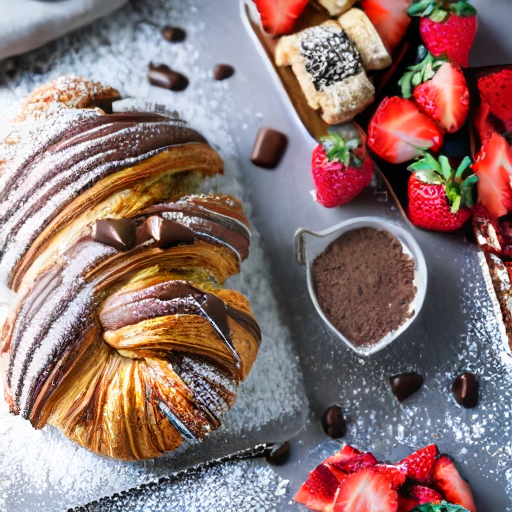

To decode these latents


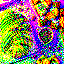

SD-VAE (left) takes 1.1425s; TAESD (right) takes 0.0461s


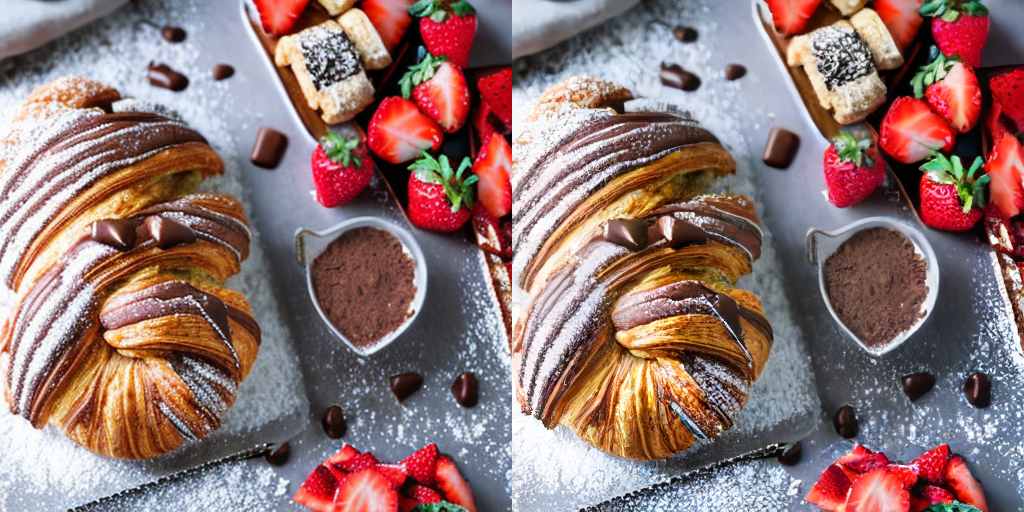

In [7]:
preview_images.clear()
preview_handle = None
generator = torch.Generator(device).manual_seed(0x7A35D13)
image = pipe(prompt, num_inference_steps=35, height=512, width=512, guidance_scale=7.5, generator=generator).images[0]
display(image)

In [8]:
from IPython.display import HTML
import base64
preview_images[0].save("images/preview_images_1.gif", save_all=True, append_images=preview_images[1:], duration=100, loop=0)
HTML("<img src=../images/preview_images_1.gif />")